## Project 4   Hack-a-thon

### Max Bermont, Yunus Herman, Grant Hicks

### Problem Statement:

We have been tasked with creating a model that will predict if a person's income is greater than \\$50,000 given certain profile information. The information that we were given to create our model is from an extraction of data from the 1994 Census database. Since the client which hired us to create the model wants things to be as 'cost-efficient' as possible, they only provided us with a limited amount of data to create our model. We want to know if we can make a prediction if someone is likely to have an income of greater than \\$50,000 using the limited amount of data that we have at our disposal.

In [1]:
#Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier

### Reading in the Data

In [2]:
# Reading in the dataframe as df

df = pd.read_csv('./data/cheap_train_sample.csv')

In [3]:
# Checking come basic info, determining data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6513 entries, 0 to 6512
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             6513 non-null   int64 
 1   workclass       6513 non-null   object
 2   fnlwgt          6513 non-null   int64 
 3   education       6513 non-null   object
 4   education-num   6513 non-null   int64 
 5   marital-status  6513 non-null   object
 6   occupation      6513 non-null   object
 7   relationship    6513 non-null   object
 8   sex             6513 non-null   object
 9   capital-gain    6513 non-null   int64 
 10  capital-loss    6513 non-null   int64 
 11  hours-per-week  6513 non-null   int64 
 12  native-country  6513 non-null   object
 13  wage            6513 non-null   object
dtypes: int64(6), object(8)
memory usage: 712.5+ KB


We have 6,513 rows with 14 columns. So far it looks like there are no null values, but we will have to same some values to numerical values.

In [4]:
# Looking at description of numerical data

df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,6513.000000,6.513000e+03,6513.000000,6513.000000,6513.000000,6513.000000
mean,38.529556,1.926640e+05,10.068478,1059.200829,92.108092,40.400891
std,13.684351,1.060173e+05,2.589238,7392.040587,413.710886,12.354685
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,27.000000,1.202380e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.815760e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.417530e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.366120e+06,16.000000,99999.000000,4356.000000,99.000000


<AxesSubplot:>

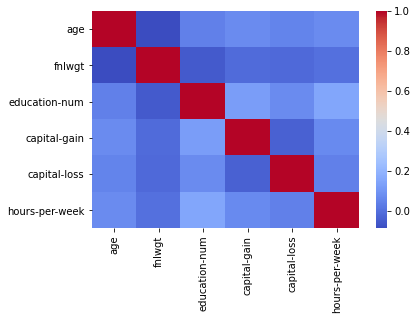

In [5]:
# Checking correlation heatmap for any standout correlations

sns.heatmap(df.corr(), cmap='coolwarm')

In [6]:
# clean object features to be numeric.
# a lot of features for a limited amount of unique data points.

df.workclass.value_counts()

 Private             4545
 Self-emp-not-inc     504
 Local-gov            421
 ?                    363
 State-gov            262
 Self-emp-inc         225
 Federal-gov          189
 Never-worked           2
 Without-pay            2
Name: workclass, dtype: int64

In [8]:
# good spread of values representing the data, however will use entire feature allotment.
# Already have numerical column

df.education.value_counts()

 HS-grad         2103
 Some-college    1451
 Bachelors       1113
 Masters          334
 Assoc-voc        250
 11th             225
 Assoc-acdm       222
 10th             175
 7th-8th          142
 9th              106
 Prof-school      103
 12th              89
 Doctorate         81
 5th-6th           79
 1st-4th           27
 Preschool         13
Name: education, dtype: int64

In [9]:
df['marital-status'].value_counts()

 Married-civ-spouse       2978
 Never-married            2135
 Divorced                  898
 Separated                 210
 Widowed                   204
 Married-spouse-absent      81
 Married-AF-spouse           7
Name: marital-status, dtype: int64

In [10]:
df['occupation'].value_counts()

 Exec-managerial      853
 Prof-specialty       840
 Craft-repair         831
 Adm-clerical         761
 Other-service        684
 Sales                681
 Machine-op-inspct    377
 ?                    365
 Transport-moving     320
 Handlers-cleaners    268
 Farming-fishing      184
 Tech-support         182
 Protective-serv      129
 Priv-house-serv       36
 Armed-Forces           2
Name: occupation, dtype: int64

In [11]:
df['relationship'].value_counts()

 Husband           2612
 Not-in-family     1665
 Own-child         1019
 Unmarried          701
 Wife               322
 Other-relative     194
Name: relationship, dtype: int64

In [12]:
df['sex'].value_counts()

 Male      4326
 Female    2187
Name: sex, dtype: int64

In [13]:
df['native-country'].value_counts()

 United-States                 5807
 Mexico                         150
 ?                              120
 Philippines                     43
 El-Salvador                     29
 Canada                          26
 Germany                         24
 Dominican-Republic              20
 South                           18
 Jamaica                         18
 China                           17
 Puerto-Rico                     17
 India                           17
 Cuba                            16
 England                         16
 Italy                           15
 Poland                          14
 Japan                           12
 Haiti                           11
 Columbia                        11
 Guatemala                       11
 Taiwan                          10
 Iran                            10
 France                           9
 Peru                             9
 Vietnam                          8
 Cambodia                         6
 Nicaragua                  

## Preparing the Data

In [14]:
# Creating dummy variables set to 1 or 0 for features in the dataframe

df = pd.get_dummies(df, columns=['occupation','relationship', 'sex', 'marital-status',
                                 'workclass', 'native-country'],
                    drop_first=True)

In [15]:
df.wage.value_counts()
#below or equal to 50k will be true.

 <=50K    4945
 >50K     1568
Name: wage, dtype: int64

In [16]:
# Creating our y-column

df['wage'] = [1 if wage == ' <=50K' else 0 for wage in df.wage]

In [17]:
df.wage.value_counts()

1    4945
0    1568
Name: wage, dtype: int64

In [18]:
# Splitting the data into our train and test sets, we are dropping the 'education' column as
# they also provied us with a numerical version of that column

X = df.drop(columns=['wage', 'education'])
features = X.columns
y = df['wage']

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=420)

In [19]:
# Baseline score

guess = [1 if pred == 1 else 0 for pred in y]
sum(guess)/len(guess)

0.7592507293106096

## Checking Models

#### Random Forest

In [20]:
rfc = RandomForestClassifier()

cross_val_score(rfc, X,y, cv=5).mean()

0.8489163020938328

#### SVC

In [21]:
svc = SVC()
cross_val_score(svc,X,y,cv= 5).mean()

0.7683099264016751

#### Ada boost

In [22]:
boost = AdaBoostClassifier()

cross_val_score(boost,X,y,cv=5).mean()

0.8576684078924567

#### Logistic Regression

In [23]:
logr= LogisticRegression()

cross_val_score(logr,X,y,cv=5).mean()

C:\Users\ghick\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ghick\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.7925708485557964

#### Decision Tree

In [24]:
tree = DecisionTreeClassifier()

cross_val_score(tree, X,y,cv=5).mean()

0.8025495931048873

#### Extra Trees

In [25]:
x_trees = ExtraTreeClassifier()

cross_val_score(x_trees, X,y,cv= 5).mean()

0.7821246727096751

#### K-Nearest Neighbors

In [26]:
knn = KNeighborsClassifier()

cross_val_score(knn, X,y,cv= 5).mean()

0.7643179570246141

|         TEST        | Cross Val Score |
|:-------------------:|:---------------:|
| Random Forest       | 0.8477          |
| SVC                 | 0.7683          |
| Ada boost           | 0.8577          |
| Logistic Regression | 0.7926          |
| Decision Tree       | 0.8036          |
| Extra Trees         | 0.7887          |
| K-Nearest Neighbors | 0.7643          |
|                     |                 |

With these scores we decided to move forward using an ada boost model. We found it to have the best score while being the least overfit of the models that we ran.

### Setting up models with pipeline

We did some testing setting up a pipeline for our models to confrim that there was not something to tweak in another model that would get us a better score than the ada boost.

In [27]:
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
pipe.fit(X_train, y_train)
print(f'Training Score: ', pipe.score(X_train,y_train))
print(f'Validation Score: ', pipe.score(X_val, y_val))
predictions = pipe.predict(X_val)
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

Training Score:  0.8656838656838657
Validation Score:  0.8158379373848987
[[ 214  167]
 [ 133 1115]]
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       381
           1       0.87      0.89      0.88      1248

    accuracy                           0.82      1629
   macro avg       0.74      0.73      0.73      1629
weighted avg       0.81      0.82      0.81      1629



In [28]:
pipe = Pipeline([('scaler', StandardScaler()),('boost', AdaBoostClassifier())])
pipe.fit(X_train, y_train)
print(f'Training Score: ', pipe.score(X_train,y_train))
print(f'Validation Score: ', pipe.score(X_val, y_val))

Training Score:  0.8486895986895987
Validation Score:  0.861878453038674


In [29]:
predictions = pipe.predict(X_val)
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

[[ 246  135]
 [  90 1158]]
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       381
           1       0.90      0.93      0.91      1248

    accuracy                           0.86      1629
   macro avg       0.81      0.79      0.80      1629
weighted avg       0.86      0.86      0.86      1629



Our ada boost still leaves us with the best score, and the fewest amount of false negaitves, which had been worrying us as the number of false negatives always seemed to be large compared to the total number of negatives.

### Adjusting paramaters with grid gearch

To further nail down how we can improve the model and perhaps get rid of some of those faslse negatives we looked to tune the parameters with a grid search.

In [31]:
boost = AdaBoostClassifier()
boost.fit(X_train,y_train)

values = boost.feature_importances_

feat = pd.DataFrame(features)
feat['values'] = values

feat.sort_values(by= 'values', ascending=False).head(20)

,0,values
2,education-num,0.12
3,capital-gain,0.12
5,hours-per-week,0.12
1,fnlwgt,0.12
0,age,0.10
4,capital-loss,0.06
25,sex_ Male,0.04
27,marital-status_ Married-civ-spouse,0.04
24,relationship_ Wife,0.04
9,occupation_ Exec-managerial,0.02


In [30]:
#weight features and adjust hyperparameters.
#what if for feature with an importance below .1  we multiply the
estimators = np.random.randint(10,300,90)
params = dict(n_estimators= estimators)

grid = GridSearchCV(AdaBoostClassifier(), param_grid=params, n_jobs=-1, cv= 5)
grid.fit(X_train,y_train)
print(f'Training Score: ', grid.score(X_train,y_train))
print(f'Validation Score: ', grid.score(X_val,y_val))
print(grid.best_params_)
print(grid.best_score_)

Training Score:  0.8718263718263718
Validation Score:  0.8514426028238183
{'n_estimators': 298}
0.8529896639092571


In [ ]:
l_rate = np.logspace(-2,0,10)
estimators = np.random.randint(100,200,5)
criterion = ('friedman_mse', 'mse', 'mae')
max_features = (None, 'sqrt', 'log2')
params = dict(n_estimators= estimators,
              learning_rate= l_rate,
              criterion= criterion,
              max_features= max_features)

The grid search provided us with the best paramets to use with our model.

## Conclusion


Our final models performs much better than the baseline with an accuracy of 87% on our testing data. We were able to put together a model with the data provided to us and tweak our features and parameters to create the best model that we could with the given data.